# SMOOTHİNG METHODS (HOLT-WİNTERS)

In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.datasets.utils import Dataset
import statsmodels.tsa.api as smt  #Zaman serisni bileşenlerine ayırmak için kullanılır.


In [2]:
warnings.filterwarnings('ignore')


Veri Seti
- Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
- Period of Record: March 1958 - December 2001
- 1958 den 2001 yılına kadar hava kirliliğini ölçmüş. amacımız bir sonraki periyotta hava kirliliği seviyesini tahmin etmek olacak.

In [3]:
#sm içinden co2 datasetini yükle diyorum.
data = sm.datasets.co2.load_pandas()  

In [4]:
data

<class 'statsmodels.datasets.utils.Dataset'>

In [5]:
#bağımlı değişken oluşturulur
y = data.data 
y
#bu veri setinin haftalık olduğu görülmektedir.

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


CO2 miktarını tahmin edeceğim için aylık tahmin yapmma daha mantıklı olacak gibi. Bu nedenle veri setini aylık formata çeviriyorum.

In [6]:
#ms=aylık olduğu frekans bilgisi
y = y["co2"].resample('MS').mean()
y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [7]:
y.isnull().sum()


5

In [8]:
#bir sonraki değer ile eksikliği doldur.
y = y.fillna(y.bfill())


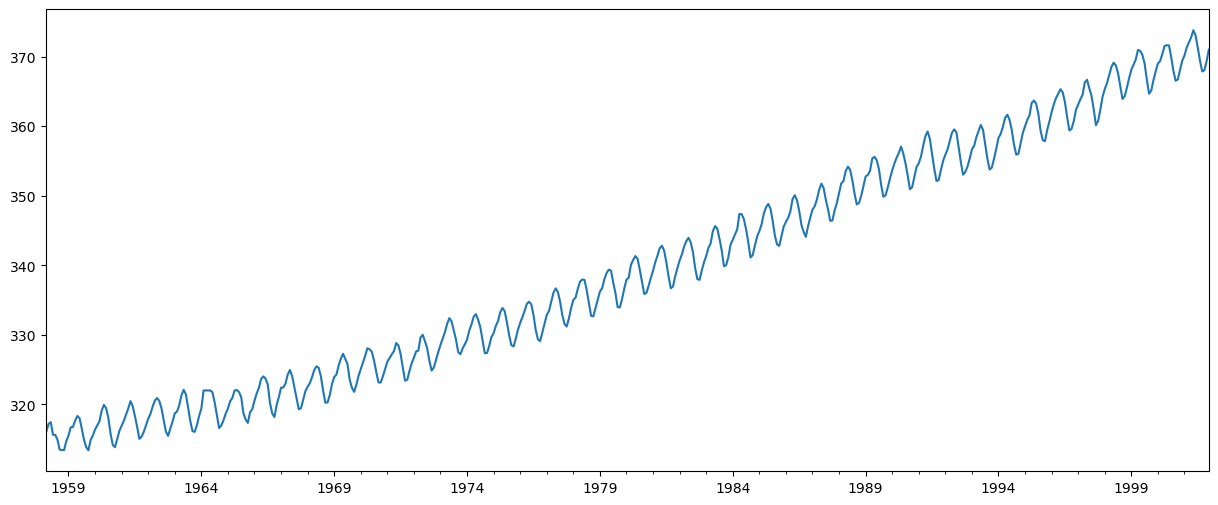

In [9]:
y.plot(figsize=(15, 6))
plt.show()

grafiğe bakınca bir trend olduğu görülmektedir.
durağan değildir.
mevsimsellik vardır.

In [10]:
# Holdout

#y nin tüm gözlem birimlerini seç am a1997-12-01 e kadar.
train = y[:'1997-12-01']
len(train)  # 478 değer varmış. 478 ay


478

In [11]:
# 1998'ilk ayından 2001'in sonuna kadar test set.
test = y['1998-01-01':]
len(test)  # 48 ay


48

modeller aşırı öğrenmeye meyillidir. burada train de model kurulur. modelin görmediği test setinde tahmin yapılır. burada cross validation yapmak saçma olur. cunku zaman serilerini 4 e bölüp, 1 iinde uyguladığında var olan trend, mevsimsellik kırılacak. bu neenle zaman serilerinde cross validation uygulamak doğru değildir.

# Zaman Serisi Yapısal Analizi


Durağanlık Testi (Dickey-Fuller Testi) --> bu test bize bir serinin durağan olup olmadığını verir.
Durağan olup olmadığını grafiğe bakarak söyleyebiliyordum. ancak burada istatiski olarak da durağan mı değil mi? bunu netleştirmek için bu test uygulanır.

In [12]:
#p value 0.05 den küçüük ise seri durağandır.
#p value 0.05 den büyük ise durağan değildir.


def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})") #
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

is_stationary(y)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


Zaman Serisi Bileşenleri ve Durağanlık Testi
- zaman serisinin yapısal özelliklerini tanımlayan bileşenler LEVEL bileşenidir. Serinin ortalama değerlerini verir.

BİLEŞENLER: LEVEL, TREND, MEVSİMSELLİK, NOİCE(artıklar,hatalar)

In [13]:
#bu fonksiyon hem durağanlık testi uygular hem de serinin bileşenlerini çıkarıp görselleştiren bir fonksiyondur.
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)


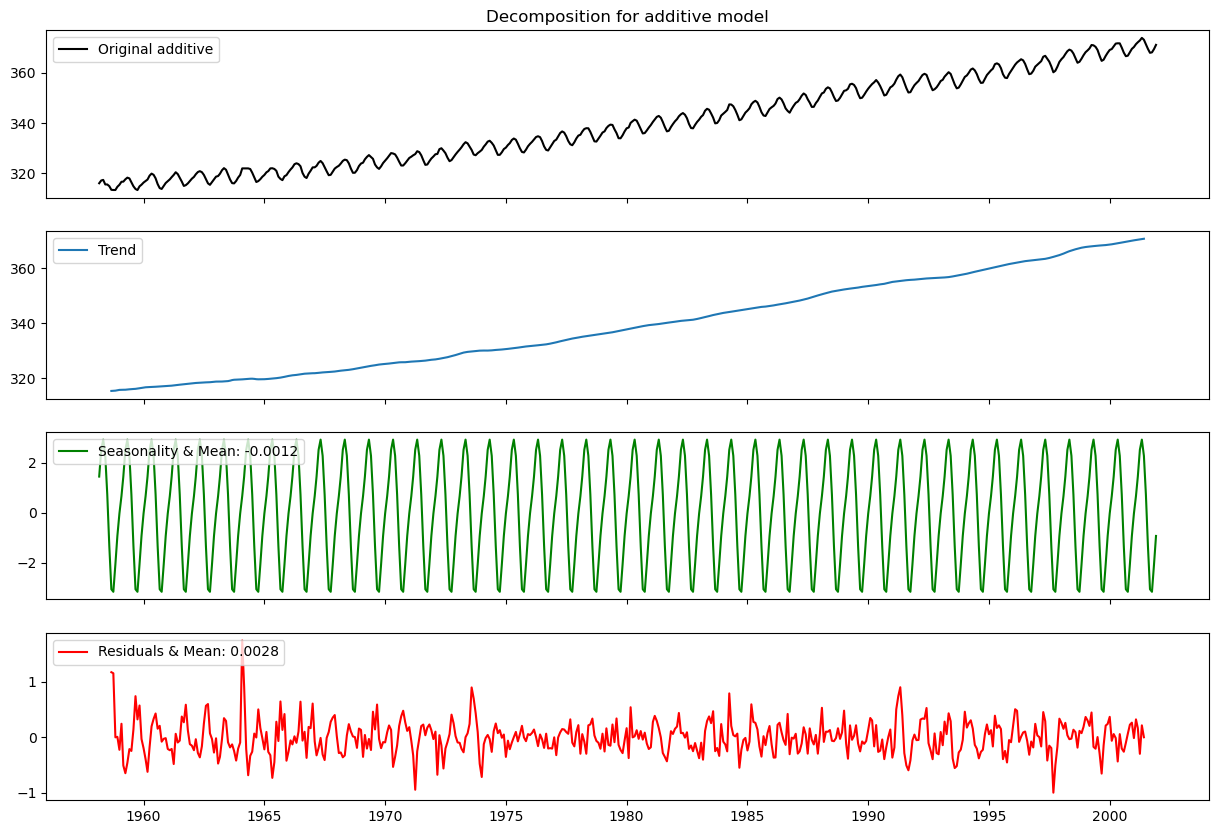

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [14]:
ts_decompose(y, stationary=True)
#stationary=True --> girilerek durağanlık bilgiside konsola yazdırılır.

Karşına çıkan grafikler;
- original additive = level bileşenini temsil eder.
- trend
- seasonality and mean = mevsimsellik bileşeni
- residuals and mean = artıklar

#Bu bileşenlere biz tek grafikten bakıp, yorumlayabiliyorduk. Ancak burada daha ayrıntılı her bileşene özel çıkan grafikte yorumlayarak daha net yapısal analiz yapılabilmekte.

#Bir zaman serisinde artıkların ortalama etrafında şekillenmesi beklenir. burada ortalama 0 ve bunun etrafında şekillenmiş.
#bir zaman serisinde artıkların ortalamasının da 0 olması beklenir. burada 0.0028 imiş.

# Single Exponential Smoothing (SES)
Level i modelliyordu. (SES =LEVEL)
Durağan serilerde kullanılır.
Seride "trend ve mevsimsellik" varsa başarılı olmaz. 



In [15]:
#biz burada smoothing_level =0.5 olarak girdik. 
#girmeseydikde max. olabilirlik yöntemiyle zaten en doğru smoothing faktörünü (alfa değerini) "SimpleExpSmoothing Methodu" buluyor olacaktı. 
#ilerde beta, gama dışsal parametrelerde gelecek. bunları tahmin etmek kola olmadığı için dışsla olarak biz bu level değerini girdik.

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

#model kuruldu.

In [16]:
#predict değilde forecast kullanılır.
#kaç adımlık bir tahmin yapacağım --> 48.
#çünkü test setimin boyutu 48 idi.

y_pred = ses_model.forecast(48)


In [17]:
#hatamızı değerlendirmek için yani tahmin sonuçlarım ile gerçek değerleri kıyaslamak istiyorum.
# MAE, MSE, RMSE metrikleri kullanılabilir.
#ortalama mutlak hata için;
mean_absolute_error(test, y_pred)


5.706393369643809

seride trend olduğu için birbirini tekrar eden değerleri görüyoruz.


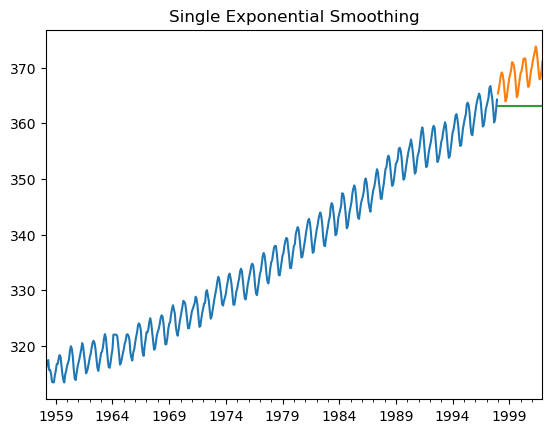

In [18]:

train.plot(title="Single Exponential Smoothing") #train setini görselleştir.
test.plot()  #test setini görselleştir.
y_pred.plot() #test setine ilişkin tahmin ettiğim değerleri de görselleştir.
plt.show()

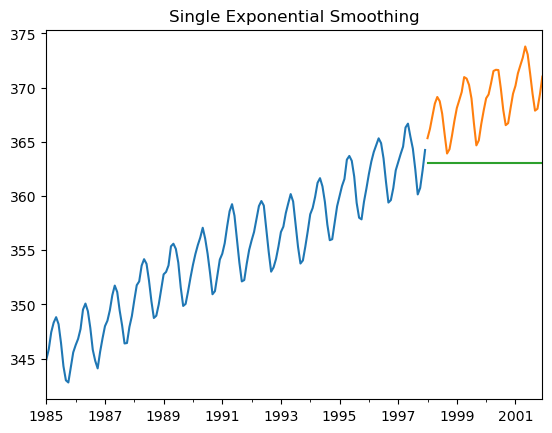

In [19]:
#daha net bir görüntü için train setinin 1985 den sonraki değerlerine bak.
#model oldukça kötü gözüküyor. yeşil çizgi, sabit bir tahminde bulunmuş.
train["1985":].plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()


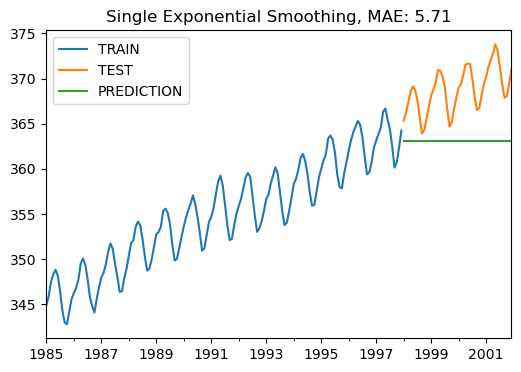

In [20]:
#biraz önceki frafikleştirdiğim görselleri fonksiyon ile tanımlıyorum.
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [21]:
ses_model.params


{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.441930977257,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

# SES Hyperparameter Optimization

SES Formülü    -->    yt_sapka = a * yt-1 + (1-a)* (yt_-1)_sapka

Formülün ilk yarısı: geçmiş gerçek değer.
Formülün ikinci yarısı: geçmiş tahmin edilen değer.
alfa da bu iki terimin ağırlığını oluşturur. peki ya bu alfa ne olacak? deneyeceğiz.

In [22]:
#farklı alfa değerlerine karşılık hatam ne olacak? bunu gözlemlemek istiyorum.
def ses_optimizer(train, alphas, step=48):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

#alfa= 0.8 den 1 e kadar 0.01 artacak şekilde alfalar üret.
alphas = np.arange(0.8, 1, 0.01)



In [23]:
#en düşük hata değerini best_alpha:... olarak verir.
ses_optimizer(train, alphas)


alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451


(0.9900000000000002, 4.545056761011273)

In [24]:
#best_alpha ve best_mae değerini tutuyorum.
best_alpha, best_mae = ses_optimizer(train, alphas)


alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451


In [25]:
# Final SES Model
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)


In [26]:
#final ses modelinin başarısı için: (aslında burada yukarıdaki best_alpha, best mae değerinin sonuçlarını getirecek.)
y_pred = ses_model.forecast(48)


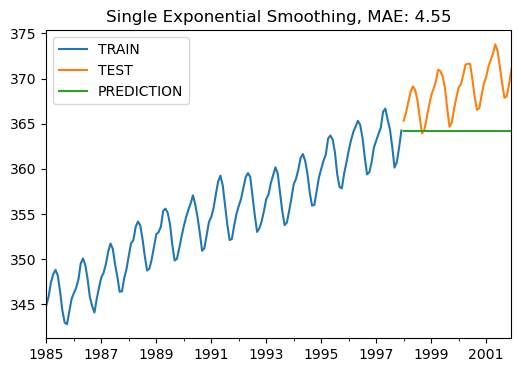

In [27]:
#model başarılı gözükmüyor. 
plot_co2(train, test, y_pred, "Single Exponential Smoothing")


# Double Exponential Smoothing (DES)
 - LEVEL ve trendi modelleyebilmektedir.
 -  DES: Level (SES) + Trend
 - y(t) = Level + Trend + Seasonality + Noise  --> TOPLAMSAL MODEL
 - y(t) = Level * Trend * Seasonality * Noise  --> ÇARPIMSAL MODEL

Çarpımsal mı ,Toplamsal mı bir model kuruyoruz?
Çarpımsal bir seri, fonksyionda çarpımsal ifadelerin olduğu anlamını taşır. bu nedenle fonksiyonel yapı daha bağımlı bir şekilde değişir.

* bir seri çarpımsal mı yoksa toplamsal mı? bunun için mevsimsellik ve artık bileşenleri eğer trendden bağımsız ise seri toplamsaldır denir. 
 
* mevsimsellik ve artık bileşenleri eğer trend ile bağımlı ise (yani trende göre şekilleniyorsa) o zaman çarpımsaldır denir.

* artık= gerçek değerler ile tahmin edilen değerlerin farkları. yani hatalardır.

* hataların(residuals asn mean grafiğine bak) ve mevsimselliğin ortalamsının 0 etrafında olması trendden bağımsız olması anlamına gelir. BU duurmda seri TOPLAMSALDIR deriz.

*sen iki modelide kur hangisinin hatası düşükse onu kullan.

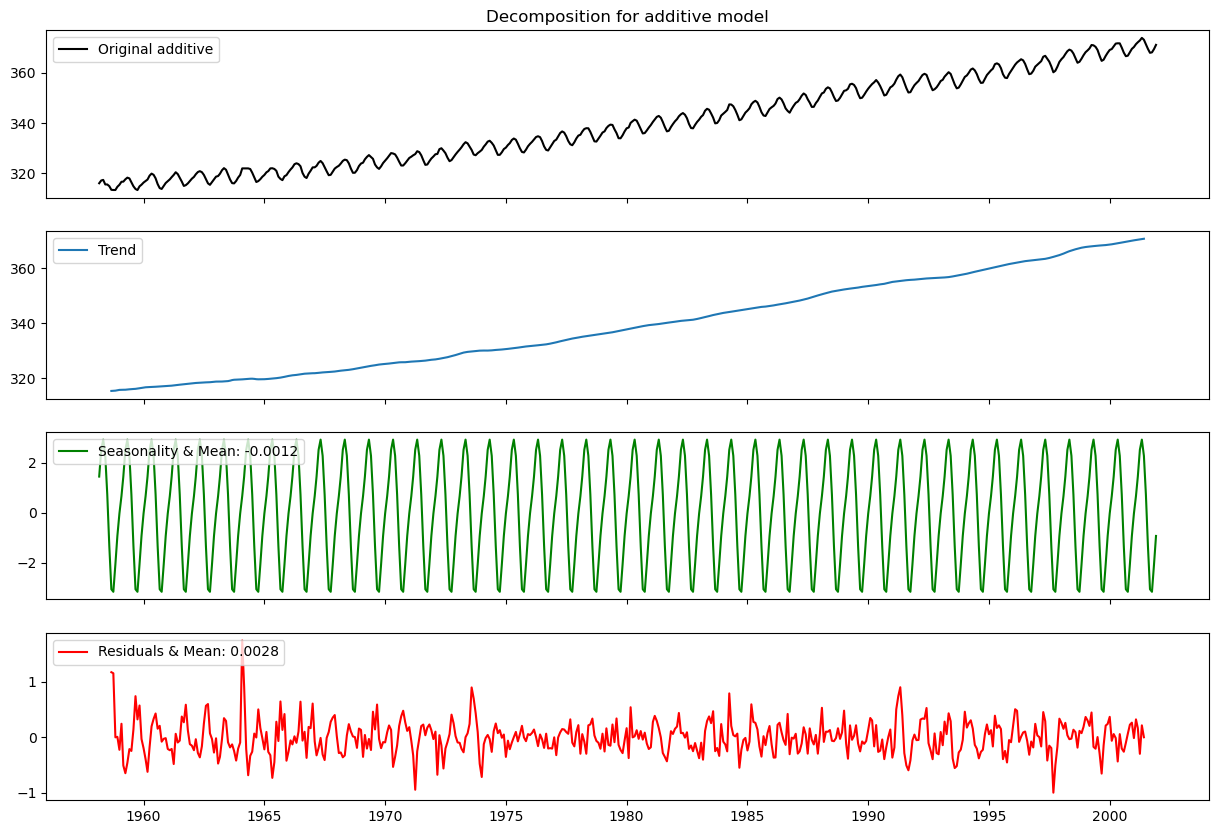

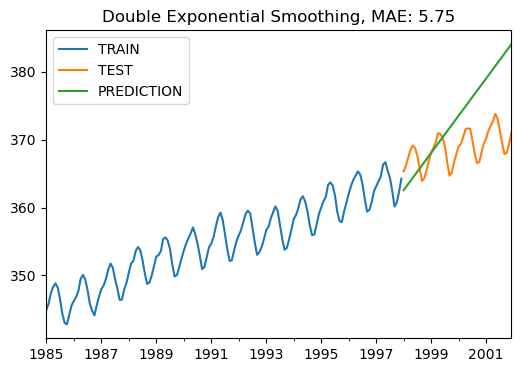

In [28]:
ts_decompose(y)
#trend=add dedim --> eklemeli.
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.5, #alfa değeri
                                                         smoothing_trend=0.5) #beta değeri

y_pred = des_model.forecast(48)

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

In [29]:
# Hyperparameter Optimization

def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

In [30]:
alphas = np.arange(0.01, 1, 0.10)

In [31]:
betas = np.arange(0.01, 1, 0.10)


In [32]:
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)


alpha: 0.01 beta: 0.01 mae: 2.3849
alpha: 0.01 beta: 0.11 mae: 2.8294
alpha: 0.01 beta: 0.21 mae: 2.744
alpha: 0.01 beta: 0.31 mae: 2.1723
alpha: 0.01 beta: 0.41 mae: 2.8895
alpha: 0.01 beta: 0.51 mae: 2.49
alpha: 0.01 beta: 0.61 mae: 1.8196
alpha: 0.01 beta: 0.71 mae: 1.7411
alpha: 0.01 beta: 0.81 mae: 2.1932
alpha: 0.01 beta: 0.91 mae: 4.8522
alpha: 0.11 beta: 0.01 mae: 2.4334
alpha: 0.11 beta: 0.11 mae: 3.9118
alpha: 0.11 beta: 0.21 mae: 6.0908
alpha: 0.11 beta: 0.31 mae: 7.2434
alpha: 0.11 beta: 0.41 mae: 8.7305
alpha: 0.11 beta: 0.51 mae: 10.3166
alpha: 0.11 beta: 0.61 mae: 12.0066
alpha: 0.11 beta: 0.71 mae: 13.9772
alpha: 0.11 beta: 0.81 mae: 16.4873
alpha: 0.11 beta: 0.91 mae: 19.655
alpha: 0.21 beta: 0.01 mae: 2.8218
alpha: 0.21 beta: 0.11 mae: 5.7217
alpha: 0.21 beta: 0.21 mae: 8.6538
alpha: 0.21 beta: 0.31 mae: 11.7598
alpha: 0.21 beta: 0.41 mae: 15.5277
alpha: 0.21 beta: 0.51 mae: 20.1474
alpha: 0.21 beta: 0.61 mae: 25.5273
alpha: 0.21 beta: 0.71 mae: 31.2781
alpha: 0.21 be

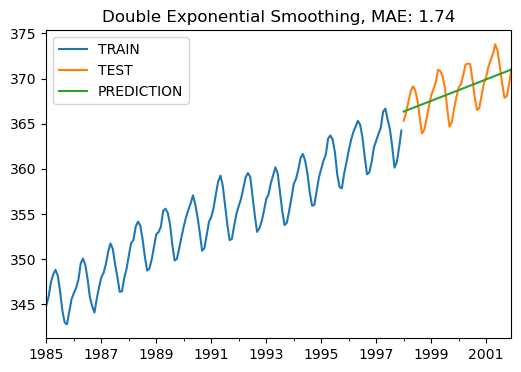

In [33]:
# Final DES Model
#toplamsal modeli kur.
final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)
y_pred = final_des_model.forecast(48)
plot_co2(train, test, y_pred, "Double Exponential Smoothing")

#çarpımsal modeli kur.
final_des_model = ExponentialSmoothing(train, trend="mul").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)
y_pred = final_des_model.forecast(48)
plot_co2(train, test, y_pred, "Double Exponential Smoothing")

toplamsal ve çarpımsal mae değerlerine baktığında toplamsal değerin hatanın az olduğunu gördüğümüz için o modeli seçiyorum.

# Triple Exponential Smoothing (Holt-Winters)
 TES = SES + DES + Mevsimsellik


In [34]:
#add olarak girdiğimiz için model toplamsal şuan.
tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)


In [35]:
y_pred = tes_model.forecast(48)


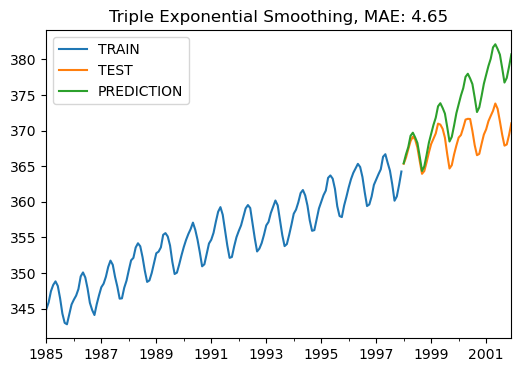

In [36]:
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")


In [37]:
# Hyperparameter Optimization
alphas = betas = gammas = np.arange(0.20, 1, 0.10)


In [38]:
#olası 3 parametrenin (alfa,beta,gamma) birliktelikleri gelmiş olur.
abg = list(itertools.product(alphas, betas, gammas))


In [39]:
def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [40]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)


[0.2, 0.2, 0.2, 0.88]
[0.2, 0.2, 0.3, 0.79]
[0.2, 0.2, 0.4, 0.76]
[0.2, 0.2, 0.5, 0.75]
[0.2, 0.2, 0.6, 0.72]
[0.2, 0.2, 0.7, 0.67]
[0.2, 0.2, 0.8, 0.67]
[0.2, 0.2, 0.9, 0.71]
[0.2, 0.3, 0.2, 0.86]
[0.2, 0.3, 0.3, 0.93]
[0.2, 0.3, 0.4, 0.94]
[0.2, 0.3, 0.5, 0.95]
[0.2, 0.3, 0.6, 1.09]
[0.2, 0.3, 0.7, 1.43]
[0.2, 0.3, 0.8, 1.95]
[0.2, 0.3, 0.9, 1.73]
[0.2, 0.4, 0.2, 1.63]
[0.2, 0.4, 0.3, 1.74]
[0.2, 0.4, 0.4, 1.64]
[0.2, 0.4, 0.5, 1.68]
[0.2, 0.4, 0.6, 2.3]
[0.2, 0.4, 0.7, 4.39]
[0.2, 0.4, 0.8, 11.66]
[0.2, 0.4, 0.9, 4.52]
[0.2, 0.5, 0.2, 2.46]
[0.2, 0.5, 0.3, 2.52]
[0.2, 0.5, 0.4, 1.94]
[0.2, 0.5, 0.5, 1.82]
[0.2, 0.5, 0.6, 1.84]
[0.2, 0.5, 0.7, 3.35]
[0.2, 0.5, 0.8, 4.63]
[0.2, 0.5, 0.9, 3.62]
[0.2, 0.6, 0.2, 3.37]
[0.2, 0.6, 0.3, 3.11]
[0.2, 0.6, 0.4, 0.72]
[0.2, 0.6, 0.5, 1.08]
[0.2, 0.6, 0.6, 1.64]
[0.2, 0.6, 0.7, 2.67]
[0.2, 0.6, 0.8, 2607.05]
[0.2, 0.6, 0.9, 121442448334.81]
[0.2, 0.7, 0.2, 4.72]
[0.2, 0.7, 0.3, 4.56]
[0.2, 0.7, 0.4, 6.58]
[0.2, 0.7, 0.5, 0.64]
[0.2, 0.7, 0.6, 1.

In [41]:
# Final TES Model

final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)


In [42]:
y_pred = final_tes_model.forecast(48)


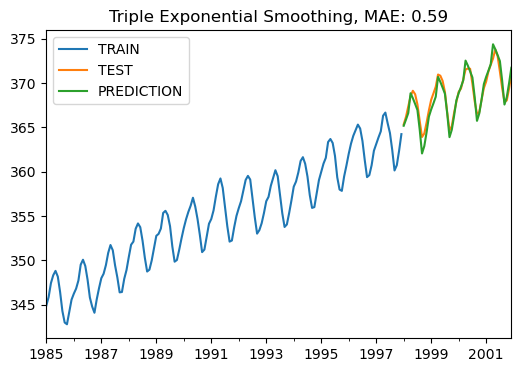

In [43]:
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")
